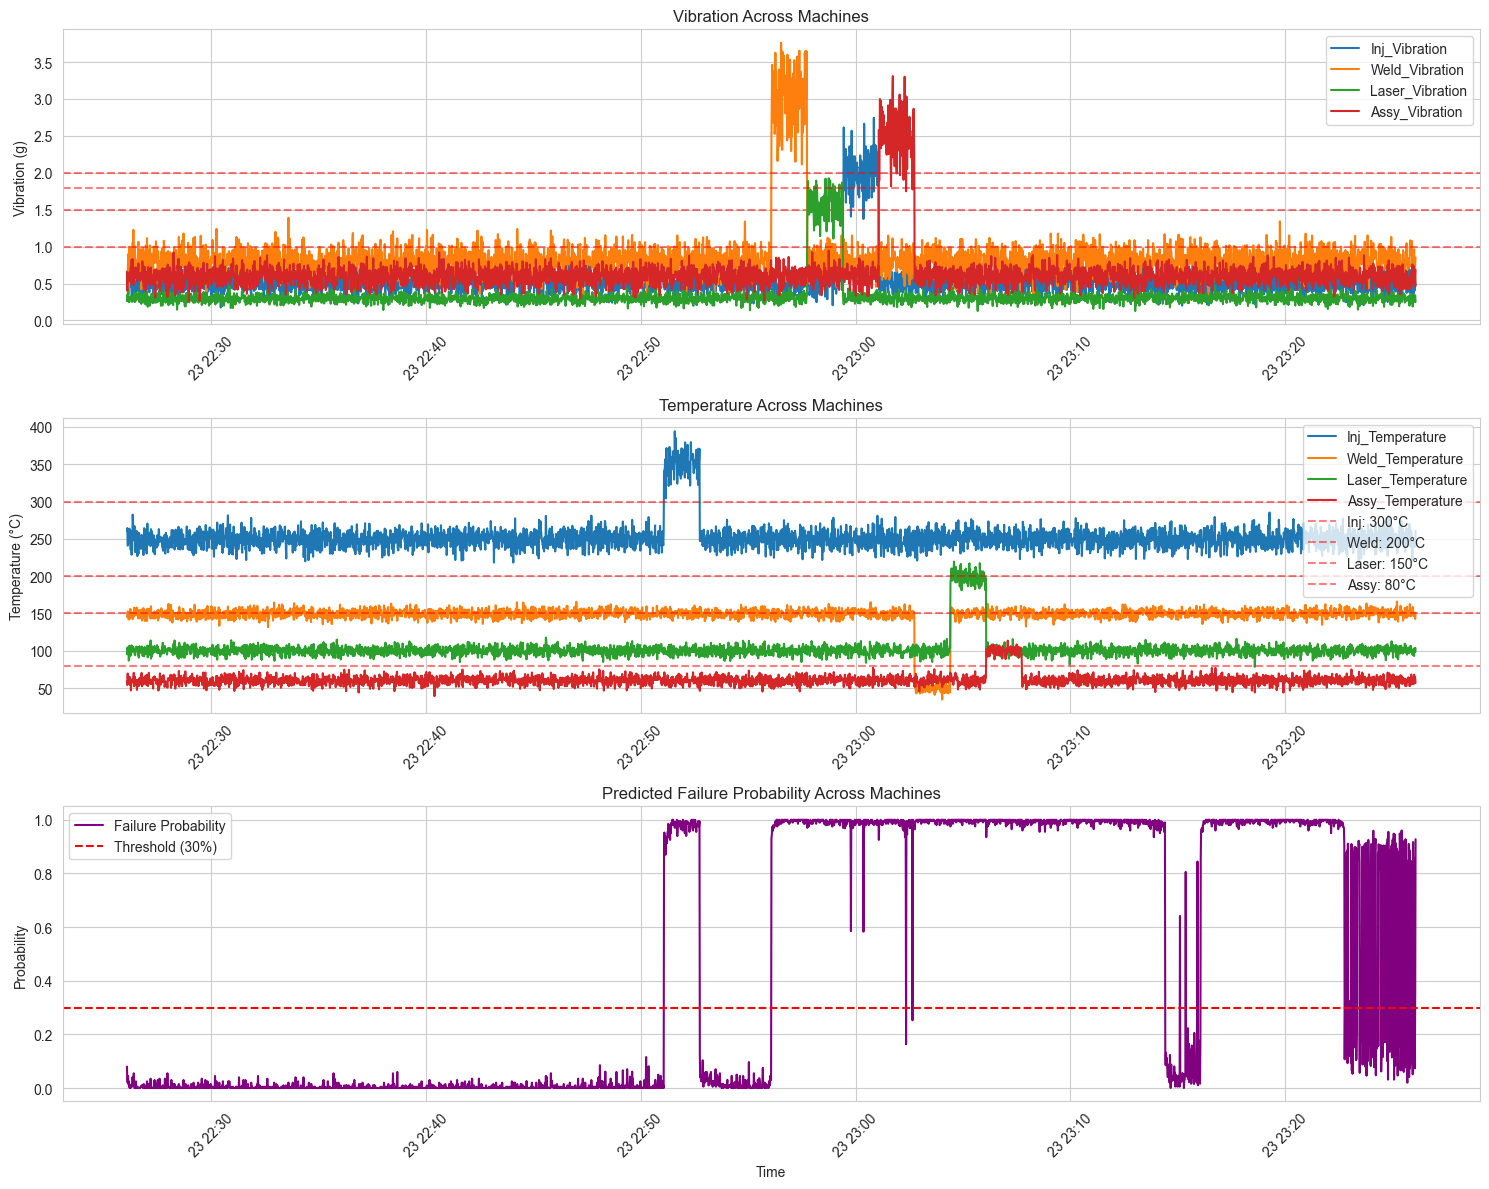

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Disable GPU for consistency
torch.cuda.set_device(-1) if torch.cuda.is_available() else None

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Simulate time series data (1 hour, 1-second intervals)
n_samples = 3600
time_index = [datetime.now() + timedelta(seconds=i) for i in range(n_samples)]

# Simulate sensor data
vibration_inj = np.random.normal(0.5, 0.1, n_samples)
vibration_inj[2000:2100] = np.random.normal(2.0, 0.3, 100)
temp_inj = np.random.normal(250, 10, n_samples)
temp_inj[1500:1600] = np.random.normal(350, 15, 100)
oil_inj = np.linspace(100, 95, n_samples) + np.random.normal(0, 0.5, n_samples)
pressure_inj = np.random.normal(5, 0.2, n_samples)
pressure_inj[2500:2600] = np.random.normal(3, 0.2, 100)
quality_inj = np.random.normal(2, 0.5, n_samples)
quality_inj[3000:3100] = np.random.normal(10, 1, 100)

vibration_weld = np.random.normal(0.8, 0.15, n_samples)
vibration_weld[1800:1900] = np.random.normal(3.0, 0.4, 100)
temp_weld = np.random.normal(150, 5, n_samples)
temp_weld[2200:2300] = np.random.normal(50, 5, 100)
oil_weld = np.linspace(100, 98, n_samples) + np.random.normal(0, 0.3, n_samples)
pressure_weld = np.random.normal(6, 0.2, n_samples)
pressure_weld[2700:2800] = np.random.normal(4, 0.2, 100)
quality_weld = np.random.normal(1.5, 0.4, n_samples)
quality_weld[3200:3300] = np.random.normal(8, 1, 100)

vibration_laser = np.random.normal(0.3, 0.05, n_samples)
vibration_laser[1900:2000] = np.random.normal(1.5, 0.2, 100)
temp_laser = np.random.normal(100, 5, n_samples)
temp_laser[2300:2400] = np.random.normal(200, 10, 100)
oil_laser = np.linspace(100, 99, n_samples) + np.random.normal(0, 0.2, n_samples)
pressure_laser = np.random.normal(4, 0.1, n_samples)
pressure_laser[2600:2700] = np.random.normal(2, 0.1, 100)
quality_laser = np.random.normal(0.5, 0.1, n_samples)
quality_laser[3100:3200] = np.random.normal(5, 0.5, 100)

vibration_assy = np.random.normal(0.6, 0.1, n_samples)
vibration_assy[2100:2200] = np.random.normal(2.5, 0.3, 100)
temp_assy = np.random.normal(60, 5, n_samples)
temp_assy[2400:2500] = np.random.normal(100, 5, 100)
oil_assy = np.linspace(100, 96, n_samples) + np.random.normal(0, 0.4, n_samples)
pressure_assy = np.random.normal(7, 0.2, n_samples)
pressure_assy[2800:2900] = np.random.normal(4, 0.2, 100)
quality_assy = np.random.normal(1, 0.3, n_samples)
quality_assy[3300:3400] = np.random.normal(7, 0.7, 100)

# Create initial DataFrame
data = pd.DataFrame({
    'Time': time_index,
    'Inj_Vibration': vibration_inj, 'Inj_Temperature': temp_inj, 'Inj_Oil': oil_inj,
    'Inj_Pressure': pressure_inj, 'Inj_Quality': quality_inj,
    'Weld_Vibration': vibration_weld, 'Weld_Temperature': temp_weld, 'Weld_Oil': oil_weld,
    'Weld_Pressure': pressure_weld, 'Weld_Quality': quality_weld,
    'Laser_Vibration': vibration_laser, 'Laser_Temperature': temp_laser, 'Laser_Oil': oil_laser,
    'Laser_Pressure': pressure_laser, 'Laser_Quality': quality_laser,
    'Assy_Vibration': vibration_assy, 'Assy_Temperature': temp_assy, 'Assy_Oil': oil_assy,
    'Assy_Pressure': pressure_assy, 'Assy_Quality': quality_assy
})

# Feature engineering with SciPy and Scikit-learn
window = 60
feature_dfs = [data]
for col in data.columns[1:]:
    features = {
        f'{col}_roll_avg': data[col].rolling(window=window, min_periods=1).mean(),
        f'{col}_roll_std': data[col].rolling(window=window, min_periods=1).std().fillna(0),
        f'{col}_rate_change': data[col].diff().fillna(0),
        f'{col}_lag_60': data[col].shift(60).bfill(),
        f'{col}_anomaly_flag': (data[col] > data[col].quantile(0.95)).astype(int)
    }
    if 'Vibration' in col:
        freqs, power = signal.periodogram(data[col], fs=1.0)
        dominant_power = power[np.argmax(power[1:]) + 1]
        features[f'{col}_fft_power'] = np.full(n_samples, dominant_power)
    feature_dfs.append(pd.DataFrame(features))
data = pd.concat(feature_dfs, axis=1)

# Prepare ML features
feature_cols = [col for col in data.columns if col.endswith('_Vibration') or col.endswith('_Temperature') or
                col.endswith('_Oil') or col.endswith('_Pressure') or col.endswith('_Quality') or
                col.endswith('_roll_avg') or col.endswith('_roll_std') or col.endswith('_rate_change') or
                col.endswith('_lag_60') or col.endswith('_anomaly_flag') or col.endswith('_fft_power')]
X = data[feature_cols]

# Create synthetic labels with machine-specific thresholds
labels = np.zeros(n_samples, dtype=int)
labels = np.logical_or(labels, data['Inj_Vibration'] > 1.5)
labels = np.logical_or(labels, data['Weld_Vibration'] > 2.0)
labels = np.logical_or(labels, data['Laser_Vibration'] > 1.0)
labels = np.logical_or(labels, data['Assy_Vibration'] > 1.8)
labels = np.logical_or(labels, data['Inj_Temperature'] > 300)
labels = np.logical_or(labels, data['Weld_Temperature'] < 100)
labels = np.logical_or(labels, data['Weld_Temperature'] > 200)
labels = np.logical_or(labels, data['Laser_Temperature'] > 150)
labels = np.logical_or(labels, data['Assy_Temperature'] > 80)
labels = np.logical_or(labels, data['Inj_Oil'] < 95)
labels = np.logical_or(labels, data['Weld_Oil'] < 96)
labels = np.logical_or(labels, data['Laser_Oil'] < 97)
labels = np.logical_or(labels, data['Assy_Oil'] < 94)
labels = np.logical_or(labels, data['Inj_Pressure'] < 4.0)
labels = np.logical_or(labels, data['Weld_Pressure'] < 5.0)
labels = np.logical_or(labels, data['Laser_Pressure'] < 3.5)
labels = np.logical_or(labels, data['Assy_Pressure'] < 5.5)
labels = np.logical_or(labels, data['Inj_Quality'] > 5)
labels = np.logical_or(labels, data['Weld_Quality'] > 4)
labels = np.logical_or(labels, data['Laser_Quality'] > 3)
labels = np.logical_or(labels, data['Assy_Quality'] > 4)
labels = labels.astype(int)

# Scale features and impute NaNs
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_pca, labels)

# Train PyTorch Neural Network
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Prepare data for PyTorch
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
model = MLP(input_dim=X_pca.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(10):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Predict failure probabilities
model.eval()
with torch.no_grad():
    nn_probs = model(X_tensor).numpy().flatten()

# Average RF and NN probabilities
rf_probs = rf_model.predict_proba(X_pca)[:, 1]
failure_probs = (rf_probs + nn_probs) / 2
data['Failure_Probability'] = failure_probs

# Export for Tableau
data.to_csv('sensor_data.csv', index=False)

# Create dashboard
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")

# Plot 1: Vibration
plt.subplot(3, 1, 1)
for col, thresh in zip(['Inj_Vibration', 'Weld_Vibration', 'Laser_Vibration', 'Assy_Vibration'], [1.5, 2.0, 1.0, 1.8]):
    plt.plot(data['Time'], data[col], label=col)
    plt.axhline(y=thresh, color='r', linestyle='--', alpha=0.5)
plt.title('Vibration Across Machines')
plt.ylabel('Vibration (g)')
plt.legend()
plt.xticks(rotation=45)

# Plot 2: Temperature
plt.subplot(3, 1, 2)
for col in ['Inj_Temperature', 'Weld_Temperature', 'Laser_Temperature', 'Assy_Temperature']:
    plt.plot(data['Time'], data[col], label=col)
plt.axhline(y=300, color='r', linestyle='--', alpha=0.5, label='Inj: 300°C')
plt.axhline(y=200, color='r', linestyle='--', alpha=0.5, label='Weld: 200°C')
plt.axhline(y=150, color='r', linestyle='--', alpha=0.5, label='Laser: 150°C')
plt.axhline(y=80, color='r', linestyle='--', alpha=0.5, label='Assy: 80°C')
plt.title('Temperature Across Machines')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)

# Plot 3: Failure Probability
plt.subplot(3, 1, 3)
plt.plot(data['Time'], data['Failure_Probability'], label='Failure Probability', color='purple')
plt.axhline(y=0.3, color='r', linestyle='--', label='Threshold (30%)')
plt.title('Predicted Failure Probability Across Machines')
plt.ylabel('Probability')
plt.xlabel('Time')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sensor_ml_dashboard.png')

In [7]:
window = 60
feature_dfs = [data]
for col in data.columns[1:]:
    features = {
        f'{col}_roll_avg': data[col].rolling(window=window, min_periods=1).mean(),
        f'{col}_roll_std': data[col].rolling(window=window, min_periods=1).std().fillna(0),
        f'{col}_rate_change': data[col].diff().fillna(0),
        f'{col}_lag_60': data[col].shift(60).bfill(),
        f'{col}_anomaly_flag': (data[col] > data[col].quantile(0.95)).astype(int)
    }
    if 'Vibration' in col:
        freqs, power = signal.periodogram(data[col], fs=1.0)
        dominant_power = power[np.argmax(power[1:]) + 1]
        features[f'{col}_fft_power'] = np.full(n_samples, dominant_power)
    feature_dfs.append(pd.DataFrame(features))
data = pd.concat(feature_dfs, axis=1)


In [10]:
#!/bin/bash

# Check if Git is installed
if ! command -v git &> /dev/null; then
    echo "Git is not installed. Please install it from https://git-scm.com/downloads."
    exit 1
fi

# Project directory
PROJECT_DIR="predictive_maintenance_dashboard"
REPO_NAME="predictive_maintenance_dashboard"

# Get GitHub username
read -p "Enter your GitHub username: " GITHUB_USER

# Create and navigate to project directory
mkdir -p "$PROJECT_DIR"
cd "$PROJECT_DIR" || exit

# Copy files (assumes they exist in parent directory or are generated)
cp ../sensor_data_ml_dashboard.py .
cp ../.gitignore .
cp ../README.md .
python sensor_data_ml_dashboard.py  # Generate outputs

# Initialize Git repository
git init
git add sensor_data_ml_dashboard.py sensor_ml_dashboard.png sensor_data.csv .gitignore README.md
git commit -m "Initial commit: Predictive maintenance dashboard with PyTorch and Tableau"

# Set up remote repository
REPO_URL="https://github.com/$GITHUB_USER/$REPO_NAME.git"
git remote add origin "$REPO_URL"

# Push to GitHub
echo "You will be prompted for your GitHub Personal Access Token."
git push -u origin main

echo "Successfully pushed to $REPO_URL"

SyntaxError: invalid syntax (3125153660.py, line 4)